In [1]:
import csv
import scipy as sc
import collections
import glob
import subprocess
import datetime
import numpy as np
import pandas as pd

import time

from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.patches import Rectangle

from itertools import islice
from scipy import constants as const

globals()['rcParams']['axes.labelsize'] = 16
globals()['rcParams']['xtick.major.pad'] = 16
globals()['rcParams']['ytick.major.pad'] = 16
globals()['rcParams']['xtick.labelsize'] = 16
globals()['rcParams']['ytick.labelsize'] = 16
globals()['rcParams']['font.size'] = 16
globals()['rcParams']['axes.labelweight'] = 'bold'
globals()['rcParams']['axes.labelpad'] = 7.0
globals()['rcParams']['axes.grid'] = True

In [38]:
import madxmodule

s1 = time.time()
# setting bump amplitude
bumpamplist = [-0.0005,0.000,0.001,0.002,0.003,0.004,0.005]
npart = 50

basefilelist=[['lhcb4-twiss-bfpp-'+ i + '.tfs'] for i in ['m0p5','0p0','1p0','2p0','3p0','4p0','5p0']] 

errorstringlist=['']
corrlist = np.array(['MCBCH.7L5.B2', 'MCBCH.9L5.B2', 'MCBH.13L5.B2'])


# twiss file list
basetwissfilelist = [[madxmodule.Twiss('lhcb2',basefilelist[j][i],targetxc=bumpamplist[j],IPcycle='IP5',
                                       targetel="MQ.11L5.B2",
                        correctorlist=corrlist,errorseq=errorstringlist[i],
                        twisscols=madxmodule.MADtwissColumns["LHCTwiss"],
                        beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*6370.),
                              madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*6370.)])
                    for i in range(len(basefilelist[j]))] for j in range(len(basefilelist))]


# initial parameters for BFPP
initialdictlist = [[madxmodule.get_initial(fn,madxmodule.dpPb(0,-1),location='IP5') for fn in basetwissfilelist[i]] 
                   for i in range(len(basetwissfilelist))]  

s2 = time.time()
print s2-s1

995.562194109


# Checking the orbit bumps on the main beam

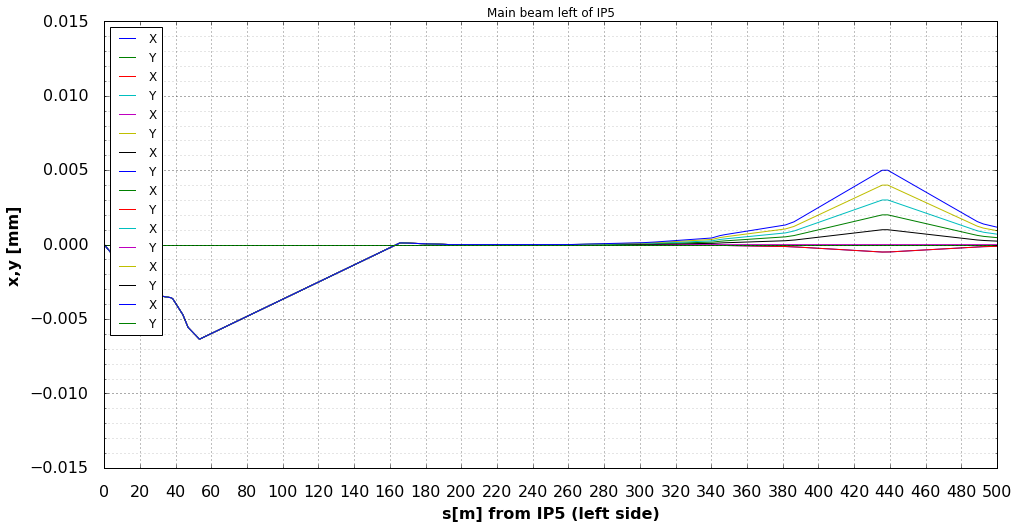

In [220]:
flist = [fn[0] for fn in [basetwissfilelist[i] for i in range(len(basetwissfilelist))]]

basedflist = [pd.read_csv(fn,
                skiprows=range(47),
                         delim_whitespace=True,
                         names =madxmodule.MADtwissColumns["LHCTwiss"])
              for fn in flist]

%matplotlib inline
df2 = basedflist[0].set_index('S')[['X','Y']]
ax = df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
for df in basedflist:
    df2 = df.set_index('S')[['X','Y']]
    df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20),ax=ax)
    plt.xlim(0,500)
    plt.xlabel('s[m] from IP5 (left side)')
    plt.ylabel('x,y [mm]')
    plt.title('Main beam left of IP5')
plt.legend(loc=2)

minor_ticks = np.arange(-0.015,0.015,0.001)
ax.set_yticks(minor_ticks,minor=True)
ax.grid(which='minor',alpha=0.4)

plt.savefig('BFPP_IP5_left_mainbeam.png',format='png')
plt.show()

# Continue the tracking

In [47]:
fileextlist = [['noerr' + i] for i in ['m0p5','0p0','1p0','2p0','3p0','4p0','5p0'] ]

transfermatrixfilelist = [
    [madxmodule.TransferMatrix('LHCB2','IP5','S.DS.L5.B2',initialdictlist[j][i],bumpamplist[j],"MQ.11L5.B2",
                               corrlist,IPcycle='IP5',errorseq=errorstringlist[i],fileext=fileextlist[j][i],
                              beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*6370.),
                                    madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*6370.)]
                             ) for i in range(len(basetwissfilelist[j]))] for j in range(len(basefilelist))]

# writing transfermatrixfilelist to file for importing and plotting
dftransfermatrixfilelist       = [pd.DataFrame(pd.Series(data=transfermatrixfilelist[j]),columns=['filename']) 
                                  for j in range(len(transfermatrixfilelist))]

for j in range(len(dftransfermatrixfilelist)):
    dftransfermatrixfilelist[j].to_csv('transfermatrixfilenamelist'+ str(j) +'.csv',index=False)

opt         = madxmodule.io.tfsDict(basetwissfilelist[0][0])
prevelinex  = opt[0]["name"].index("MB.B11L5.B2")-1
s0          = opt[0]['s'][prevelinex]
print s0

403.8427102


In [48]:
# generating the filenames for storing the impactdistributions
impactfilelist    = [['impactIP5left_bp22_' + ext for ext in fileextlist[j]] for j in range(len(fileextlist))]
impactfilelistext = [[fn+'.csv' for fn in impactfilelist[j]] for j in range(len(impactfilelist))]

dfimpactfilelist  = [pd.DataFrame(pd.Series(data=impactfilelistext[j]),columns=['filename']) 
                     for j in range(len(impactfilelist))]

npart=5000


for j in range(len(dfimpactfilelist)):
    dfimpactfilelist[j].to_csv('impactfilenamelist' + str(j) +'.csv',index=False)
    
# generating the impact distributions
for j in range(len(transfermatrixfilelist)):
    for i in range(len(transfermatrixfilelist[j])):
        madxmodule.impactcoordinates6D(madxmodule.TrackSigmaMatrix(transfermatrixfilelist[j][i],
                                                                   'MB.B11L5.B2',initialdictlist[j][i],npart)
                        ,0.02315,madxmodule.lhcradius,s0,madxmodule.dipolelength,
                                       madxmodule.dpPb(0,-1),madxmodule.ionmass,
                                       -madxmodule.electronmassgev,
                                       madxmodule.get_p(transfermatrixfilelist[j][i]),
                                       impactfilelist[j][i],beam4=True)

MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2


# Checking trajectories of  BFPP beams

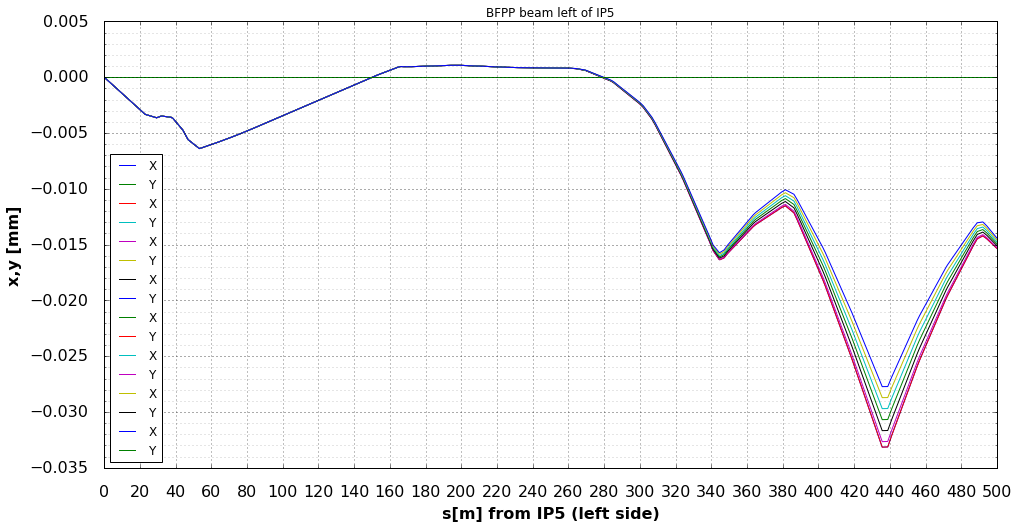

In [221]:
bfppfnlist = [fn for fn in [dftransfermatrixfilelist[i]['filename'].values[0] for i in range(len(basetwissfilelist))]]

BFPPdflist = [pd.read_csv(fn,skiprows=range(47),
                delim_whitespace=True,names =madxmodule.MADtwissColumns["RMatrixExtended"]) 
          for fn in bfppfnlist]

%matplotlib inline
df2 = BFPPdflist[0].set_index('S')[['X','Y']]
ax = df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
for df in BFPPdflist:
    df2 = df.set_index('S')[['X','Y']]
    df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20),ax=ax)
    plt.xlim(0,500)
    plt.xlabel('s[m] from IP5 (left side)')
    plt.ylabel('x,y [mm]')
    plt.title('BFPP beam left of IP5')
# plt.savefig('EMD_IP2_right.png',format='png')
minor_ticks = np.arange(-0.035,0.005,0.001)
ax.set_yticks(minor_ticks,minor=True)
ax.grid(which='minor',alpha=0.4)
plt.savefig('BFPP_IP5_left_bfppbeam.png',format='png')
plt.show()

# Impact summaries

In [64]:
data =[pd.read_csv(dfimpactfilelist[i]['filename'].values[0]) for i in range(len(dfimpactfilelist))]

[data[i].mean() for i in range(len(data))]

[s[m]           414.167576
 x[mm]          -23.142431
 px[1e-3]        -0.450976
 y[mm]           -0.005529
 py[1e-3]         0.000055
 E[GeV]      522337.429134
 dtype: float64, s[m]           414.947642
 x[mm]          -23.142599
 px[1e-3]        -0.447475
 y[mm]           -0.004149
 py[1e-3]        -0.000180
 E[GeV]      522336.737393
 dtype: float64, s[m]           416.538348
 x[mm]          -23.142423
 px[1e-3]        -0.440681
 y[mm]           -0.003594
 py[1e-3]         0.000088
 E[GeV]      522337.183404
 dtype: float64, s[m]           418.225490
 x[mm]          -23.142499
 px[1e-3]        -0.432719
 y[mm]           -0.000912
 py[1e-3]        -0.000197
 E[GeV]      522336.086635
 dtype: float64, s[m]           420.000458
 x[mm]          -23.142784
 px[1e-3]        -0.419754
 y[mm]            0.003947
 py[1e-3]        -0.000139
 E[GeV]      522337.994830
 dtype: float64, s[m]           421.915115
 x[mm]          -23.142547
 px[1e-3]        -0.406035
 y[mm]            0.020207
 p

# Tilted beampipe?

In [105]:
# first estimate
from scipy import constants
beta1 = np.arctan(np.tan(data[2].mean()['px[1e-3]']*0.001)*(416.54-416.2)/(415.-416.2))
beta2 = np.arctan(np.tan(data[3].mean()['px[1e-3]']*0.001)*(418.23-417.2)/(415.-417.2))
beta3 = np.arctan(np.tan(data[4].mean()['px[1e-3]']*0.001)*(420.-418.3)/(415.-418.3))
beta4 = np.arctan(np.tan(data[5].mean()['px[1e-3]']*0.001)*(421.92-419.0)/(415.-419.0))
beta5 = np.arctan(np.tan(data[6].mean()['px[1e-3]']*0.001)*(423.91-421.5)/(415.-421.5))

print beta1,beta2,beta3,beta4,beta5
[np.tan(beta) * (415.-420.) for beta in [beta1,beta2,beta3,beta4,beta5]]

0.000124859604619 0.000202591394679 0.00021623687125 0.000296405579905 0.000145519438707


[-0.00062429802633919799,
 -0.0010129569872538353,
 -0.0010811843730998518,
 -0.0014820279429253514,
 -0.00072759719867325793]

In [111]:
beta1p = np.arctan(np.tan(data[2].mean()['px[1e-3]']*0.001)*(416.54-416.2)/(415.-416.2))

beta2p = np.arctan((np.tan(data[3].mean()['px[1e-3]']*0.001)*(418.23-417.2) 
                    - np.tan(data[2].mean()['px[1e-3]']*0.001)*(416.54-416.2))/(416.2-417.2))

beta3p = np.arctan((np.tan(data[4].mean()['px[1e-3]']*0.001)*(420.-418.3) 
                    - np.tan(data[3].mean()['px[1e-3]']*0.001)*(418.23-417.2))/(417.2-418.3))

beta4p = np.arctan((np.tan(data[5].mean()['px[1e-3]']*0.001)*(421.92-419.0) 
                    - np.tan(data[4].mean()['px[1e-3]']*0.001)*(420.-418.3))/(418.3-420.))

beta5p = np.arctan((np.tan(data[6].mean()['px[1e-3]']*0.001)*(423.91-421.5) 
                    - np.tan(data[5].mean()['px[1e-3]']*0.001)*(421.92-419.0))/(420.-421.92))

print beta1p,beta2p,beta3p,beta4p,beta5p

0.000124859604619 0.000295869539437 0.000243527824144 0.000277670974096 -0.000124867705635


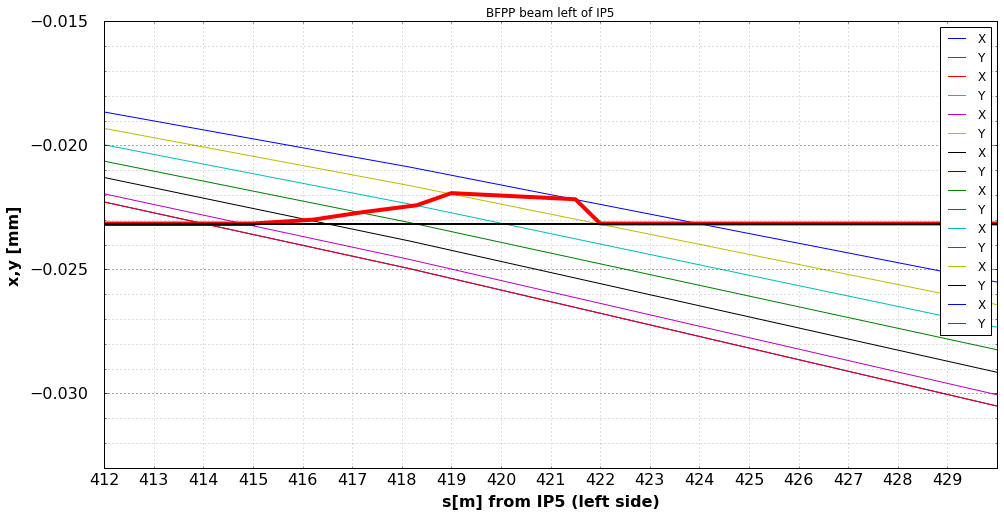

In [222]:
# genertate data points
from matplotlib.ticker import MultipleLocator,FormatStrFormatter

itab  = [-415.,-416.54,-418.23,-420.0,-421.92,-423.91]
iptab = [-415.,-416.20,-417.20,-418.3,-419.00,-421.50]
difftab = np.array(itab)- np.array(iptab)
# print difftab
y = [-0.02315+(np.tan(data[i].mean()['px[1e-3]']*0.001)) *difftab[i] for i in [1,2,3,4,5]]
y.append(-0.02315)
y.append(-0.02315)
y[:0]=[-0.02315,-0.02315]
iptab.append(-422)
iptab.append(-430)
iptab[:0]=[400,415.]

df2 = BFPPdflist[0].set_index('S')[['X','Y']]
ax = df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
for df in BFPPdflist:
    df2 = df.set_index('S')[['X','Y']]
    df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20),ax=ax)
    plt.xlim(0,500)
    plt.xlabel('s[m] from IP5 (left side)')
    plt.ylabel('x,y [mm]')
    plt.title('BFPP beam left of IP5')
    plt.plot(iptab[1:],y,color='black',linewidth=3.5)
plt.xlim(412,430)
plt.ylim(-0.033,-0.015)
plt.plot(np.array(iptab[1:])*(-1.),y)
ax.lines[-1].set_linewidth(4)
plt.plot([400,430],[-0.02315,-0.02315],color='black',linewidth=2)
minor_ticks = np.arange(-0.033,-0.015,0.001)
ax.set_yticks(minor_ticks,minor=True)
ax.grid(which='minor',alpha=0.5)

minor_xticks = np.arange(412,430,1)
ax.set_xticks(minor_xticks,minor=True)
ax.xaxis.set_minor_formatter(FormatStrFormatter('%d'))
majorlocator = MultipleLocator(100)
ax.xaxis.set_major_locator(majorlocator)
plt.savefig('BFPP_IP5_left_pipedeformation.png',format='png')
plt.show()

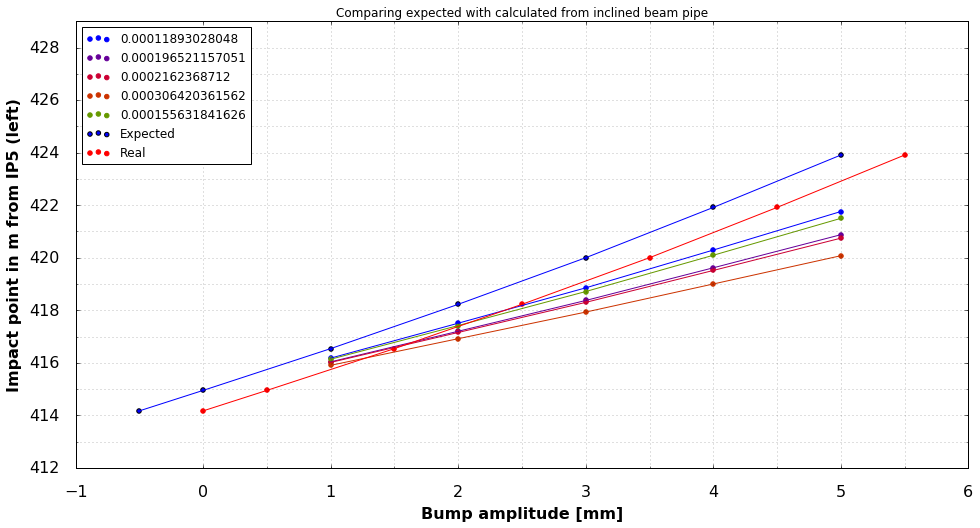

In [219]:
from scipy.optimize import fsolve
func = lambda x:np.tan(beta) *(415. - x) - np.tan(alpha)*(impact-x)
solutions =[[fsolve(func,417.)[0] for beta in [beta1,beta2,beta3,beta4,beta5]] 
            for alpha,impact in [(-0.000440681,416.51),(-0.000432719,418.23),
                                 (-0.000419754,420.0),(-0.000406035,421.92),  (-0.000392480,423.91)]]

solutions = np.transpose(solutions)    

%matplotlib inline

fig = plt.figure(figsize=(16,8))
ax = plt.gca()
mymap = plt.get_cmap('brg')
norm = plt.Normalize()
norm.autoscale(np.linspace(0,len(solutions),len(solutions)))

legend = [0.00011893028048, 0.000196521157051, 0.0002162368712, 0.000306420361562, 0.000155631841626]
for i in range(len(solutions)):
    plt.scatter([1.,2.,3.,4.,5.],solutions[i],color=mymap(float(i)/len(solutions)),label=legend[i])
    plt.plot([1.,2.,3.,4.,5.],solutions[i],color=mymap(float(i)/len(solutions)))

    
plt.plot([-0.5,0.,1.,2.,3.,4.,5.],[data[i].mean()['s[m]'] for i in range(len(data))])
plt.scatter([-0.5,0.,1.,2.,3.,4.,5.],[data[i].mean()['s[m]'] for i in range(len(data))],label='Expected')
plt.scatter([0.,0.5,1.5,2.5,3.5,4.5,5.5],[data[i].mean()['s[m]'] for i in range(len(data))],color='red',
            label='Real')
plt.plot([0.,0.5,1.5,2.5,3.5,4.5,5.5],[data[i].mean()['s[m]'] for i in range(len(data))],color='red')

plt.legend(loc=2)
plt.grid()


plt.xlabel('Bump amplitude [mm]')
plt.ylabel('Impact point in m from IP5 (left)')
plt.title('Comparing expected with calculated from inclined beam pipe')

minor_ticks = np.arange(412,430,1)
minor_xticks = np.arange(0,6,0.5)
ax.set_yticks(minor_ticks,minor=True)
ax.set_xticks(minor_xticks,minor=True)
plt.grid(which='minor',alpha=0.5)
plt.show()

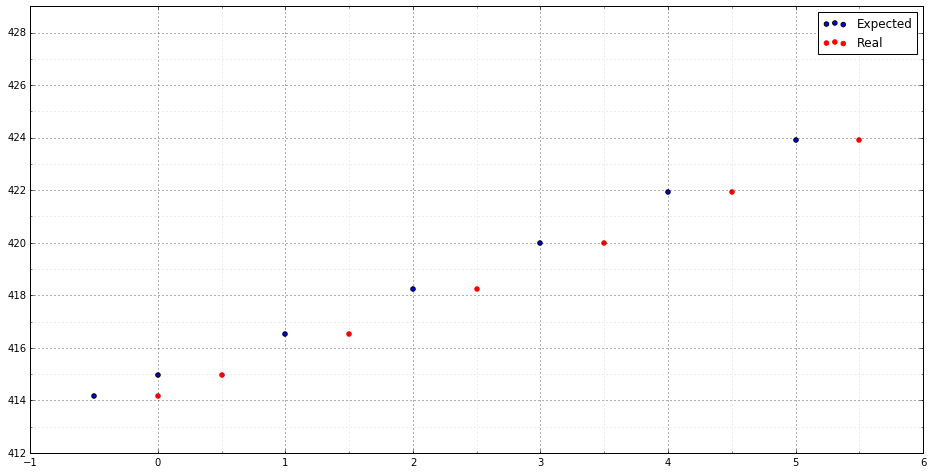

In [71]:
import csv
import scipy as sc
import collections
import glob
import subprocess
import datetime

from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.patches import Rectangle

from itertools import islice
from scipy import constants as const
%matplotlib inline



fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
plt.scatter([-0.5,0.,1.,2.,3.,4.,5.],[data[i].mean()['s[m]'] for i in range(len(data))],label='Expected')
plt.scatter([0.,0.5,1.5,2.5,3.5,4.5,5.5],[data[i].mean()['s[m]'] for i in range(len(data))],color='red',
            label='Real')
plt.legend()
plt.grid()
minor_ticks = np.arange(412,430,1)
minor_xticks = np.arange(0,6,0.5)
ax.set_yticks(minor_ticks,minor=True)
ax.set_xticks(minor_xticks,minor=True)
ax.grid(which='minor',alpha=0.3)
plt.show()
# df =pd.read_csv('lhcb1-twiss-emd.tfs',skiprows=range(47),delim_whitespace=True,names =madxmodule.MADtwissColumns["LHCTwiss"])

# Adding 0.3 mm offset vertical to MQ.11L5 (mail Jorg)

In [21]:
import madxmodule

s1 = time.time()
# setting bump amplitude
bumpamplist = [-0.0005,0.000,0.001,0.002,0.003,0.004,0.005]
npart = 50

basefilelist=[['lhcb4-twiss-bfpp-0p3errMQ11L5-'+ i + '.tfs'] for i in ['m0p5','0p0','1p0','2p0','3p0','4p0','5p0']] 

errorstringlist=['''
USE, PERIOD=LHCB2;

EOPTION,ADD=TRUE,SEED=62971100;

SELECT, FLAG=ERROR, PATTERN="MQ.11L5.B2";
EALIGN, DX:=0.30E-3;''']

corrlist = np.array(['MCBCH.7L5.B2', 'MCBCH.9L5.B2', 'MCBH.13L5.B2'])


# twiss file list
basetwissfilelist = [[madxmodule.Twiss('lhcb2',basefilelist[j][i],targetxc=bumpamplist[j],IPcycle='IP5',
                                       targetel="MQ.11L5.B2",
                        correctorlist=corrlist,errorseq=errorstringlist[i],
                        twisscols=madxmodule.MADtwissColumns["LHCTwiss"],
                        beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*6370.),
                              madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*6370.)])
                    for i in range(len(basefilelist[j]))] for j in range(len(basefilelist))]

# initial parameters for BFPP
initialdictlist = [[madxmodule.get_initial(fn.lower(),madxmodule.dpPb(0,-1),location='IP5') for fn in basetwissfilelist[i]] 
                   for i in range(len(basetwissfilelist))]  

s2 = time.time()
print s2-s1

93.6172070503


# Plotting of main beam

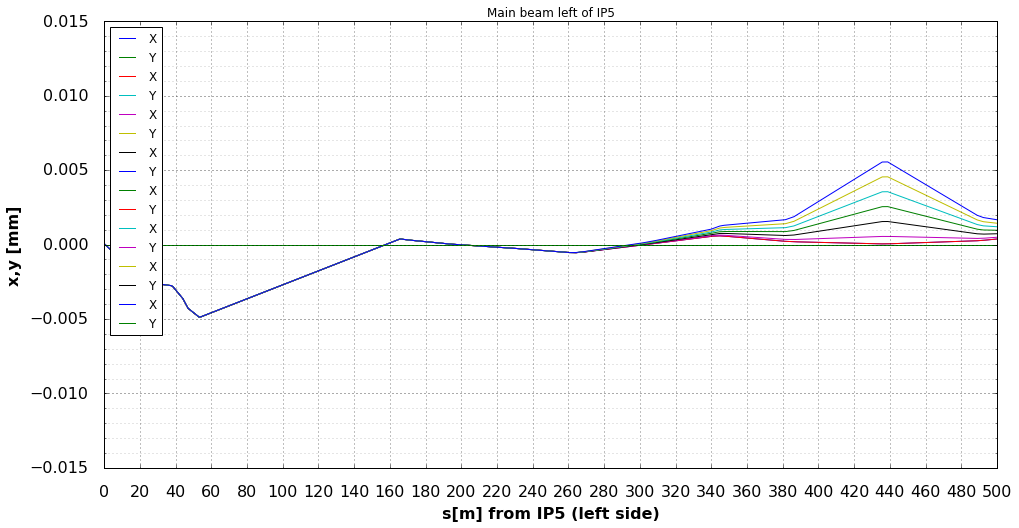

In [22]:
flist = [fn[0] for fn in [basetwissfilelist[i] for i in range(len(basetwissfilelist))]]

basedflist = [pd.read_csv(fn.lower(),
                skiprows=range(47),
                         delim_whitespace=True,
                         names =madxmodule.MADtwissColumns["LHCTwiss"])
              for fn in flist]

%matplotlib inline
df2 = basedflist[0].set_index('S')[['X','Y']]
ax = df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
for df in basedflist:
    df2 = df.set_index('S')[['X','Y']]
    df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20),ax=ax)
    plt.xlim(0,500)
    plt.xlabel('s[m] from IP5 (left side)')
    plt.ylabel('x,y [mm]')
    plt.title('Main beam left of IP5')
plt.legend(loc=2)

minor_ticks = np.arange(-0.015,0.015,0.001)
ax.set_yticks(minor_ticks,minor=True)
ax.grid(which='minor',alpha=0.4)

plt.savefig('BFPP_IP5_left_mainbeam_errmql11l5.png',format='png')
plt.show()

# Continue tracking

In [23]:
fileextlist = [['errmql11l5' + i] for i in ['m0p5','0p0','1p0','2p0','3p0','4p0','5p0'] ]

transfermatrixfilelist = [
    [madxmodule.TransferMatrix('LHCB2','IP5','S.DS.L5.B2',initialdictlist[j][i],bumpamplist[j],"MQ.11L5.B2",
                               corrlist,IPcycle='IP5',errorseq=errorstringlist[i],fileext=fileextlist[j][i],
                              beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*6370.),
                                    madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*6370.)]
                             ) for i in range(len(basetwissfilelist[j]))] for j in range(len(basefilelist))]

# writing transfermatrixfilelist to file for importing and plotting
dftransfermatrixfilelist       = [pd.DataFrame(pd.Series(data=transfermatrixfilelist[j]),columns=['filename']) 
                                  for j in range(len(transfermatrixfilelist))]

for j in range(len(dftransfermatrixfilelist)):
    dftransfermatrixfilelist[j].to_csv('transfermatrixfilenamelist'+ str(j) +'.csv',index=False)

opt         = madxmodule.io.tfsDict(basetwissfilelist[0][0].lower())
prevelinex  = opt[0]["name"].index("MB.B11L5.B2")-1
s0          = opt[0]['s'][prevelinex]
print s0

403.8427102


In [24]:
# generating the filenames for storing the impactdistributions
impactfilelist    = [['impactIP5left_bp22_' + ext for ext in fileextlist[j]] for j in range(len(fileextlist))]
impactfilelistext = [[fn+'.csv' for fn in impactfilelist[j]] for j in range(len(impactfilelist))]

dfimpactfilelist  = [pd.DataFrame(pd.Series(data=impactfilelistext[j]),columns=['filename']) 
                     for j in range(len(impactfilelist))]

npart=5000


for j in range(len(dfimpactfilelist)):
    dfimpactfilelist[j].to_csv('impactfilenamelist' + str(j) +'.csv',index=False)
    
# generating the impact distributions
for j in range(len(transfermatrixfilelist)):
    for i in range(len(transfermatrixfilelist[j])):
        madxmodule.impactcoordinates6D(madxmodule.TrackSigmaMatrix(transfermatrixfilelist[j][i],
                                                                   'MB.B11L5.B2',initialdictlist[j][i],npart)
                        ,0.02265,madxmodule.lhcradius,s0,madxmodule.dipolelength,
                                       madxmodule.dpPb(0,-1),madxmodule.ionmass,
                                       -madxmodule.electronmassgev,
                                       madxmodule.get_p(transfermatrixfilelist[j][i]),
                                       impactfilelist[j][i],beam4=True)

MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2


# Checking BFPP trajectories

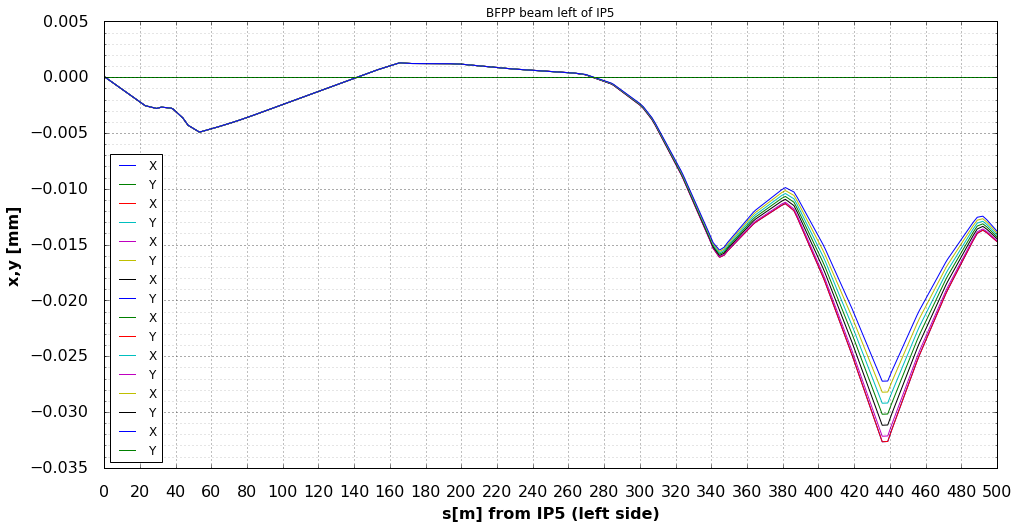

In [25]:
bfppfnlist = [fn for fn in [dftransfermatrixfilelist[i]['filename'].values[0] for i in range(len(basetwissfilelist))]]

BFPPdflist = [pd.read_csv(fn,skiprows=range(47),
                delim_whitespace=True,names =madxmodule.MADtwissColumns["RMatrixExtended"]) 
          for fn in bfppfnlist]

%matplotlib inline
df2 = BFPPdflist[0].set_index('S')[['X','Y']]
ax = df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
for df in BFPPdflist:
    df2 = df.set_index('S')[['X','Y']]
    df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20),ax=ax)
    plt.xlim(0,500)
    plt.xlabel('s[m] from IP5 (left side)')
    plt.ylabel('x,y [mm]')
    plt.title('BFPP beam left of IP5')
# plt.savefig('EMD_IP2_right.png',format='png')
minor_ticks = np.arange(-0.035,0.005,0.001)
ax.set_yticks(minor_ticks,minor=True)
ax.grid(which='minor',alpha=0.4)
plt.savefig('BFPP_IP5_left_bfppbeam.png',format='png')
plt.show()

In [26]:
errdata =[pd.read_csv(dfimpactfilelist[i]['filename'].values[0]) for i in range(len(dfimpactfilelist))]

[errdata[i].mean() for i in range(len(errdata))]

[s[m]           413.855281
 x[mm]          -22.642442
 px[1e-3]        -0.443969
 y[mm]           -0.003616
 py[1e-3]        -0.000063
 E[GeV]      522338.789011
 dtype: float64, s[m]           414.633044
 x[mm]          -22.642475
 px[1e-3]        -0.440626
 y[mm]            0.005314
 py[1e-3]         0.000106
 E[GeV]      522338.644376
 dtype: float64, s[m]           416.258032
 x[mm]          -22.642244
 px[1e-3]        -0.433662
 y[mm]            0.012301
 py[1e-3]        -0.000118
 E[GeV]      522338.311185
 dtype: float64, s[m]           417.963573
 x[mm]          -22.642343
 px[1e-3]        -0.426540
 y[mm]            0.002383
 py[1e-3]         0.000083
 E[GeV]      522340.132620
 dtype: float64, s[m]           419.743687
 x[mm]          -22.642174
 px[1e-3]        -0.414361
 y[mm]            0.003114
 py[1e-3]        -0.000013
 E[GeV]      522338.602510
 dtype: float64, s[m]           421.691733
 x[mm]          -22.642256
 px[1e-3]        -0.400371
 y[mm]            0.007907
 p

In [39]:
# first estimate
from scipy import constants
beta1 = np.arctan(np.tan(errdata[2].mean()['px[1e-3]']*0.001)*(416.25-416.2)/(414.6-416.2))
beta2 = np.arctan(np.tan(errdata[3].mean()['px[1e-3]']*0.001)*(417.96-417.2)/(414.6-417.2))
beta3 = np.arctan(np.tan(errdata[4].mean()['px[1e-3]']*0.001)*(419.74-418.3)/(414.6-418.3))
beta4 = np.arctan(np.tan(errdata[5].mean()['px[1e-3]']*0.001)*(421.69-419.0)/(414.6-419.0))
beta5 = np.arctan(np.tan(errdata[6].mean()['px[1e-3]']*0.001)*(423.75-421.5)/(414.6-421.5))

print beta1,beta2,beta3,beta4,beta5
[np.tan(beta) * (414.6-421.69) for beta in [beta1,beta2,beta3,beta4,beta5]]

1.35519438137e-05 0.000124680861908 0.000161264949572 0.000244772567861 0.000126004061349


[-9.6083281645069159e-05,
 -0.0008839873155095597,
 -0.0011433685023761913,
 -0.0017354375407900296,
 -0.00089336879969364221]

In [ ]:
416.2
417.2
418.3
419.0
421.5


# Adding -0.3 mm offset vertical to MQ.11L5 (mail Jorg)¶

In [27]:
import madxmodule

s1 = time.time()
# setting bump amplitude
bumpamplist = [-0.0005,0.000,0.001,0.002,0.003,0.004,0.005]
npart = 50

basefilelist=[['lhcb4-twiss-bfpp-m0p3errMQ11L5-'+ i + '.tfs'] for i in ['m0p5','0p0','1p0','2p0','3p0','4p0','5p0']] 

errorstringlist=['''
USE, PERIOD=LHCB2;

EOPTION,ADD=TRUE,SEED=62971100;

SELECT, FLAG=ERROR, PATTERN="MQ.11L5.B2";
EALIGN, DX:=-0.30E-3;''']

corrlist = np.array(['MCBCH.7L5.B2', 'MCBCH.9L5.B2', 'MCBH.13L5.B2'])


# twiss file list
basetwissfilelist = [[madxmodule.Twiss('lhcb2',basefilelist[j][i],targetxc=bumpamplist[j],IPcycle='IP5',
                                       targetel="MQ.11L5.B2",
                        correctorlist=corrlist,errorseq=errorstringlist[i],
                        twisscols=madxmodule.MADtwissColumns["LHCTwiss"],
                        beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*6370.),
                              madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*6370.)])
                    for i in range(len(basefilelist[j]))] for j in range(len(basefilelist))]

# initial parameters for BFPP
initialdictlist = [[madxmodule.get_initial(fn.lower(),madxmodule.dpPb(0,-1),location='IP5') for fn in basetwissfilelist[i]] 
                   for i in range(len(basetwissfilelist))]  

s2 = time.time()
print s2-s1

94.9639539719


# Plotting main beam

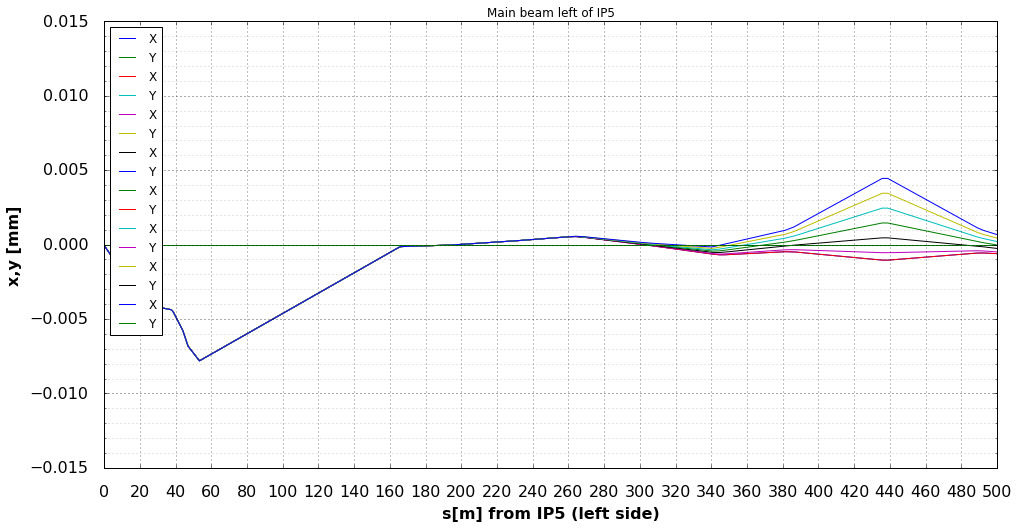

In [28]:
flist = [fn[0] for fn in [basetwissfilelist[i] for i in range(len(basetwissfilelist))]]

basedflist = [pd.read_csv(fn.lower(),
                skiprows=range(47),
                         delim_whitespace=True,
                         names =madxmodule.MADtwissColumns["LHCTwiss"])
              for fn in flist]

%matplotlib inline
df2 = basedflist[0].set_index('S')[['X','Y']]
ax = df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
for df in basedflist:
    df2 = df.set_index('S')[['X','Y']]
    df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20),ax=ax)
    plt.xlim(0,500)
    plt.xlabel('s[m] from IP5 (left side)')
    plt.ylabel('x,y [mm]')
    plt.title('Main beam left of IP5')
plt.legend(loc=2)

minor_ticks = np.arange(-0.015,0.015,0.001)
ax.set_yticks(minor_ticks,minor=True)
ax.grid(which='minor',alpha=0.4)

plt.savefig('BFPP_IP5_left_mainbeam_errmql11l5neg.png',format='png')
plt.show()

# Continue tracking

In [29]:
fileextlist = [['errmql11l5neg' + i] for i in ['m0p5','0p0','1p0','2p0','3p0','4p0','5p0'] ]

transfermatrixfilelist = [
    [madxmodule.TransferMatrix('LHCB2','IP5','S.DS.L5.B2',initialdictlist[j][i],bumpamplist[j],"MQ.11L5.B2",
                               corrlist,IPcycle='IP5',errorseq=errorstringlist[i],fileext=fileextlist[j][i],
                              beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*6370.),
                                    madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*6370.)]
                             ) for i in range(len(basetwissfilelist[j]))] for j in range(len(basefilelist))]

# writing transfermatrixfilelist to file for importing and plotting
dftransfermatrixfilelist       = [pd.DataFrame(pd.Series(data=transfermatrixfilelist[j]),columns=['filename']) 
                                  for j in range(len(transfermatrixfilelist))]

for j in range(len(dftransfermatrixfilelist)):
    dftransfermatrixfilelist[j].to_csv('transfermatrixfilenamelist'+ str(j) +'.csv',index=False)

opt         = madxmodule.io.tfsDict(basetwissfilelist[0][0].lower())
prevelinex  = opt[0]["name"].index("MB.B11L5.B2")-1
s0          = opt[0]['s'][prevelinex]
print s0

403.8427102


In [30]:
# generating the filenames for storing the impactdistributions
impactfilelist    = [['impactIP5left_bp22_errneg' + ext for ext in fileextlist[j]] for j in range(len(fileextlist))]
impactfilelistext = [[fn+'.csv' for fn in impactfilelist[j]] for j in range(len(impactfilelist))]

dfimpactfilelist  = [pd.DataFrame(pd.Series(data=impactfilelistext[j]),columns=['filename']) 
                     for j in range(len(impactfilelist))]

npart=5000


for j in range(len(dfimpactfilelist)):
    dfimpactfilelist[j].to_csv('impactfilenamelist' + str(j) +'.csv',index=False)
    
# generating the impact distributions
for j in range(len(transfermatrixfilelist)):
    for i in range(len(transfermatrixfilelist[j])):
        madxmodule.impactcoordinates6D(madxmodule.TrackSigmaMatrix(transfermatrixfilelist[j][i],
                                                                   'MB.B11L5.B2',initialdictlist[j][i],npart)
                        ,0.02265,madxmodule.lhcradius,s0,madxmodule.dipolelength,
                                       madxmodule.dpPb(0,-1),madxmodule.ionmass,
                                       -madxmodule.electronmassgev,
                                       madxmodule.get_p(transfermatrixfilelist[j][i]),
                                       impactfilelist[j][i],beam4=True)

MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2
MCS.B11L5.B2
DRIFT_54
MB.B11L5.B2


# Checking BFPP trajectories

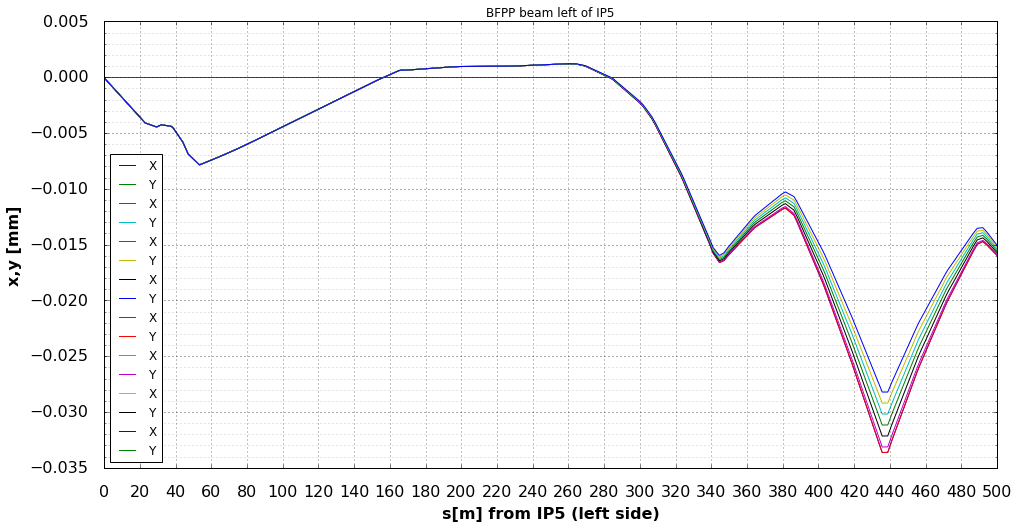

In [31]:
bfppfnlist = [fn for fn in [dftransfermatrixfilelist[i]['filename'].values[0] for i in range(len(basetwissfilelist))]]

BFPPdflist = [pd.read_csv(fn,skiprows=range(47),
                delim_whitespace=True,names =madxmodule.MADtwissColumns["RMatrixExtended"]) 
          for fn in bfppfnlist]

%matplotlib inline
df2 = BFPPdflist[0].set_index('S')[['X','Y']]
ax = df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
for df in BFPPdflist:
    df2 = df.set_index('S')[['X','Y']]
    df2.plot(figsize=(16,8),grid=True,xticks=range(0,540,20),ax=ax)
    plt.xlim(0,500)
    plt.xlabel('s[m] from IP5 (left side)')
    plt.ylabel('x,y [mm]')
    plt.title('BFPP beam left of IP5')
# plt.savefig('EMD_IP2_right.png',format='png')
minor_ticks = np.arange(-0.035,0.005,0.001)
ax.set_yticks(minor_ticks,minor=True)
ax.grid(which='minor',alpha=0.4)
plt.savefig('BFPP_IP5_left_bfppbeam.png',format='png')
plt.show()

In [32]:
negerrdata =[pd.read_csv(dfimpactfilelist[i]['filename'].values[0]) for i in range(len(dfimpactfilelist))]

[negerrdata[i].mean() for i in range(len(negerrdata))]

[s[m]           412.273191
 x[mm]          -22.642350
 px[1e-3]        -0.448169
 y[mm]           -0.003262
 py[1e-3]         0.000063
 E[GeV]      522338.686737
 dtype: float64, s[m]           413.023095
 x[mm]          -22.642375
 px[1e-3]        -0.444464
 y[mm]            0.007275
 py[1e-3]        -0.000133
 E[GeV]      522339.431764
 dtype: float64, s[m]           414.553803
 x[mm]          -22.642475
 px[1e-3]        -0.437542
 y[mm]            0.003317
 py[1e-3]         0.000199
 E[GeV]      522337.392994
 dtype: float64, s[m]           416.193402
 x[mm]          -22.642436
 px[1e-3]        -0.430734
 y[mm]           -0.002869
 py[1e-3]         0.000089
 E[GeV]      522338.487214
 dtype: float64, s[m]           417.906278
 x[mm]          -22.642424
 px[1e-3]        -0.423676
 y[mm]           -0.010433
 py[1e-3]        -0.000005
 E[GeV]      522338.442358
 dtype: float64, s[m]           419.712024
 x[mm]          -22.642099
 px[1e-3]        -0.411444
 y[mm]            0.001868
 p

In [ ]:
416.2
417.2
418.3
419.0
421.5
